In [55]:
import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt

In [56]:
sess = tf.compat.v1.Session()

c = tf.constant(3.0)
print(sess.run(c))


3.0


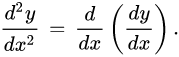  
- just a note for second-order derivative syntax
- TF GradientTape docs - https://www.tensorflow.org/api_docs/python/tf/GradientTape

-3.0
-2.9
-2.8
-2.6999999999999997
-2.5999999999999996
-2.4999999999999996
-2.3999999999999995
-2.2999999999999994
-2.1999999999999993
-2.099999999999999
-1.9999999999999991
-1.899999999999999
-1.799999999999999
-1.6999999999999988
-1.5999999999999988
-1.4999999999999987
-1.3999999999999986
-1.2999999999999985
-1.1999999999999984
-1.0999999999999983
-0.9999999999999982
-0.8999999999999981
-0.799999999999998
-0.699999999999998
-0.5999999999999979
-0.4999999999999978
-0.3999999999999977
-0.2999999999999976
-0.1999999999999975
-0.09999999999999742
2.6645352591003757e-15
0.10000000000000275
0.20000000000000284
0.30000000000000293
0.400000000000003
0.5000000000000031
0.6000000000000032
0.7000000000000033
0.8000000000000034
0.9000000000000035
1.0000000000000036
1.1000000000000032
1.2000000000000037
1.3000000000000043
1.400000000000004
1.5000000000000036
1.600000000000004
1.7000000000000046
1.8000000000000043
1.900000000000004
2.0000000000000044
2.100000000000005
2.2000000000000046
2.30000000

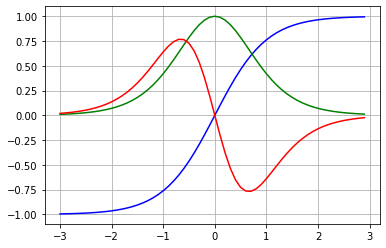

In [80]:
sess = tf.compat.v1.Session()

x_lst       = np.arange(-3, 3, 0.1)
y_lst       = []
dy_dx_lst   = []
d2y_dx2_lst = []
d3y_dx3_lst = []

for i in range(0, len(x_lst)):
    x = x_lst[i]
    print(x)
    x_tensor = tf.constant(float(x))
    
    
    
    
    x_tensor = tf.constant(x)
    with tf.GradientTape() as g:
        # tf.constants are not automatically watched by tf.GradientTape's,
        # so they have to be watched explicitly (g.watch(x)). 
        # tf.Variable's are watched automaticaly, unless their "trainable=False" is set.
        g.watch(x_tensor)
        
        
        with tf.GradientTape() as gg:
            gg.watch(x_tensor)
            
            with tf.GradientTape() as ggg:
                y_tensor = tf.math.tanh(x_tensor)
    
            # IMPORTANT!! - "dy_dx" has to be calculated within the "g" context,
            #               so that that GradientTape tracks it for the second-order 
            #               derivative calculation ("d2y_dx2"). 
            dy_dx = ggg.gradient(y_tensor, x_tensor)
        
    d2y_dx2 = g.gradient(dy_dx, x_tensor)
    
    
    y = sess.run(y_tensor)
    y_lst.append(y)
    
    dy_dx_lst.append(sess.run(dy_dx))
    d2y_dx2_lst.append(sess.run(d2y_dx2))
    
        
plt.grid(True)
plt.plot(x_lst, y_lst, "b")
plt.plot(x_lst, dy_dx_lst, "g")
plt.plot(x_lst, d2y_dx2_lst, "r")

In [73]:

import math
import numpy as np
# import tensorflow.python.framework.ops.Tensor as tensor
e = math.e
    
def run_step(p_x, p_type_str):
    
    x = tf.constant(float(p_x))
    
    #-------------------------------------------------------------
    # @tf.function 
    def f(p_input, p_type_str):
        
        if p_type_str == "sigmoid":
            # sigmoid activation fun - 1/(1+e^-x)
            output = 1/(1 + e**-p_input)
            # output = tf.math.sigmoid(p_input_var)
        
        elif p_type_str == "tanh":
            # hyperbolic tangent fun - (e^x - e^-x)/(e^x+e^-x)
            output = (e**p_input - e**-p_input) / (e**p_input + e**-p_input)
            # output = tf.math.tanh(p_input_var)
        
        elif p_type_str == "relu":
            # ReLU - Rectified Linear Unit - max(0, x)
            if sess.run(p_input) > 0: output = p_input
            else:                     output = 0.0 * p_input
            # output = tf.nn.relu(p_x)
        
        elif p_type_str == "custom":
            output     = p_input**2
            output_val = sess.run(output)
            
            if output_val > 2:
                d_above_level = output-2
                output = 2-d_above_level/2
            
            
        return output
    
    #-------------------------------------------------------------
    
    with tf.GradientTape() as g:
        # tf.constants are not automatically watched by tf.GradientTape's,
        # so they have to be watched explicitly (g.watch(x)). 
        # tf.Variable's are watched automaticaly, unless their "trainable=False" is set.
        g.watch(x)

        # y = tf.py_function(func=t, inp=[p_x], Tout=tf.float32)
        y = f(x, p_type_str)
        assert isinstance(y, tf.Tensor)

        target = y # tf.convert_to_tensor(y)
        source = x
        dy_dx  = g.gradient(target, source)

    with tf.GradientTape() as g2:
        g2.watch(x)

        z = f(x, "custom")
        assert isinstance(z, tf.Tensor)

        target = z # tf.convert_to_tensor(y)
        source = x
        dz_dx = g2.gradient(z, x)
    
        
    return y, z, dy_dx, dz_dx

In [74]:
sess = tf.compat.v1.Session()

for x in range(0, 3):
    _, _, dy_dx, _ = run_step(x, "tanh")
    print(sess.run(dy_dx))

0.99999994
0.41997433
0.070650876


In [75]:
def run_test(p_type_str):
    sess = tf.compat.v1.Session()

    x_lst = [] # np.geomspace(-2, 2, 10)
    z_lst = []
    y_lst = []
    dy_dx_lst = []
    dz_dx_lst = []

    import time

    input_lst = np.arange(-3, 3, 0.1)
    for i in range(0, len(input_lst)):
        x = input_lst[i]

        t1 = time.time()

        y, z, dy_dx, dz_dx = run_step(x, p_type_str)
        assert isinstance(y,     tf.Tensor)
        assert isinstance(z,     tf.Tensor)
        assert isinstance(dy_dx, tf.Tensor)
        assert isinstance(dz_dx, tf.Tensor)
        
        y_val     = sess.run(y)
        z_val     = sess.run(z)
        dy_dx_val = sess.run(dy_dx)
        dz_dx_val = sess.run(dz_dx)
        
        x_lst.append(x)
        z_lst.append(z_val)
        y_lst.append(y_val)
        dy_dx_lst.append(dy_dx_val)
        dz_dx_lst.append(dz_dx_val)
        
        t2 = time.time()
        print("%s/%s - %ss"%(i, len(input_lst), t2-t1))

    plt.grid(True)
    # plt.plot(x_lst, y_lst, "g")
    plt.plot(x_lst, z_lst, "b")
    # plt.plot(x_lst, dy_dx_lst, "r")
    plt.plot(x_lst, dz_dx_lst, "r")

0/60 - 2.1229135990142822s
1/60 - 2.1173384189605713s
2/60 - 2.1265361309051514s
3/60 - 2.3679497241973877s
4/60 - 2.5248348712921143s
5/60 - 2.578242301940918s
6/60 - 2.9338855743408203s
7/60 - 2.720207452774048s
8/60 - 2.7227959632873535s
9/60 - 2.735929250717163s
10/60 - 2.726350784301758s
11/60 - 2.751636505126953s
12/60 - 2.7450168132781982s
13/60 - 2.769923686981201s
14/60 - 2.753915548324585s
15/60 - 2.768068552017212s
16/60 - 2.7412846088409424s
17/60 - 2.7629811763763428s
18/60 - 2.7957937717437744s
19/60 - 2.773797035217285s
20/60 - 2.7838430404663086s
21/60 - 2.762174367904663s
22/60 - 2.7812089920043945s
23/60 - 2.7761318683624268s
24/60 - 2.8079142570495605s
25/60 - 2.783256769180298s
26/60 - 2.771949291229248s
27/60 - 2.7850356101989746s
28/60 - 2.7719953060150146s
29/60 - 2.8050379753112793s
30/60 - 2.783095598220825s
31/60 - 2.7883946895599365s
32/60 - 2.763684034347534s
33/60 - 2.789604425430298s
34/60 - 2.793267011642456s
35/60 - 2.789292335510254s
36/60 - 2.807417392

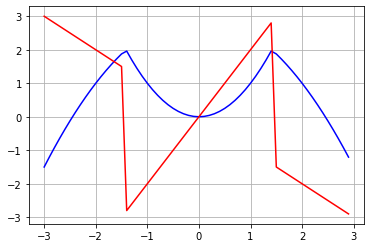

In [76]:
run_test("custom")

In [ ]:
run_test("sigmoid")

0/50 - 2.900290012359619s
1/50 - 2.999386787414551s
2/50 - 3.0536813735961914s
3/50 - 3.0227138996124268s
4/50 - 2.9659628868103027s
5/50 - 3.00416898727417s
6/50 - 3.029707670211792s
7/50 - 3.121809720993042s
8/50 - 3.0761871337890625s
9/50 - 3.1806631088256836s
10/50 - 3.3004560470581055s
11/50 - 3.0840611457824707s
12/50 - 3.074636459350586s
13/50 - 3.072382926940918s
14/50 - 3.0765480995178223s
15/50 - 3.130251407623291s
16/50 - 3.04445481300354s
17/50 - 3.087456703186035s
18/50 - 3.037914514541626s
19/50 - 3.0250842571258545s
20/50 - 3.1892664432525635s
21/50 - 3.3776509761810303s
22/50 - 3.319929361343384s
23/50 - 3.2174863815307617s
24/50 - 3.1818294525146484s
25/50 - 3.221303701400757s
26/50 - 3.3188376426696777s
27/50 - 3.0871071815490723s
28/50 - 3.110757350921631s
29/50 - 3.2453033924102783s
30/50 - 3.2856578826904297s
31/50 - 3.111389398574829s
32/50 - 3.1179301738739014s
33/50 - 3.1504688262939453s
34/50 - 3.1249923706054688s
35/50 - 3.0869240760803223s
36/50 - 3.161593198

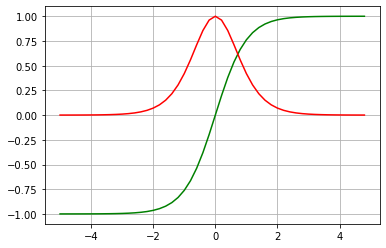

In [157]:
run_test("tanh")

0/50 - 5.322201490402222s
1/50 - 5.2376837730407715s
2/50 - 5.204629182815552s
3/50 - 5.209854602813721s
4/50 - 5.6322340965271s
5/50 - 5.369730234146118s
6/50 - 5.259985685348511s
7/50 - 5.252997398376465s
8/50 - 5.605458498001099s
9/50 - 5.319669008255005s
10/50 - 5.425795793533325s
11/50 - 5.558258533477783s
12/50 - 5.574413537979126s
13/50 - 5.2905871868133545s
14/50 - 5.2599427700042725s
15/50 - 5.357506513595581s
16/50 - 5.198545932769775s
17/50 - 5.311051845550537s
18/50 - 5.4887707233428955s
19/50 - 5.465182065963745s
20/50 - 5.62846302986145s
21/50 - 5.592763900756836s
22/50 - 5.47521185874939s
23/50 - 5.673851490020752s
24/50 - 5.515314817428589s
25/50 - 5.568107843399048s
26/50 - 5.549628973007202s
27/50 - 5.485443830490112s
28/50 - 5.700120687484741s
29/50 - 5.556420803070068s
30/50 - 5.345186471939087s
31/50 - 5.3015289306640625s
32/50 - 5.296907901763916s
33/50 - 5.315702199935913s
34/50 - 5.265882253646851s
35/50 - 5.331820726394653s
36/50 - 5.313354015350342s
37/50 - 5.

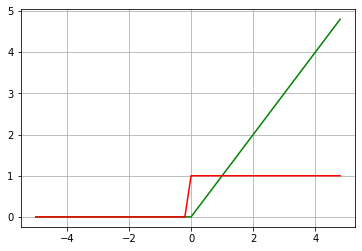

In [158]:
run_test("relu")

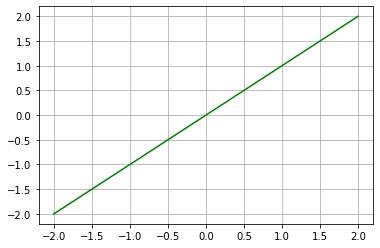

In [24]:
x = np.linspace(-2, 2, 1000)
y = np.linspace(-2, 2, 1000)
# print(x)

plt.grid(True)
plt.plot(x,y,'g')